# Data Setup

In [1]:
import pandas as pd

df_heart = pd.read_csv(
    "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data",
    sep=",",
    header=0,
    index_col=0,
)
columns_ordered = [
    "sbp",
    "ldl",
    "adiposity",
    "obesity",
    "typea",
    "age",
    "tobacco",
    "alcohol",
    "famhist",
    "chd",
]
missing = [c for c in columns_ordered if c not in df_heart.columns]
if missing:
    raise KeyError(f"Missing columns in df_heart: {missing}")

df_heart = df_heart[columns_ordered]

### Standardize data

In [2]:
import numpy as np

# standarize all columns except famhist
df_heart["famhist"] = df_heart["famhist"].map({"Present": 1, "Absent": 0})

columns_to_log_transform = ["tobacco", "alcohol"]
for column in columns_to_log_transform:
    df_heart[column] = np.log1p(df_heart[column])

df_heart_standarized = (df_heart - df_heart.mean()) / df_heart.std()
df_heart_standarized["famhist"] = df_heart["famhist"]

# Extract Y before standardization
Y = df_heart["chd"]

df_heart_standarized = (df_heart - df_heart.mean()) / df_heart.std()
df_heart_standarized["famhist"] = df_heart["famhist"]

X = df_heart_standarized.drop(columns=["chd"])
X.head()

,sbp,ldl,adiposity,obesity,typea,age,tobacco,alcohol,famhist
row.names,,,,,,,,,
1,1.057417,0.477894,-0.295183,-0.176594,-0.418017,0.628654,1.576878,1.772852,1
2,0.276789,-0.159507,0.411694,0.670646,0.193134,1.381617,-1.193044,-0.563821,0
3,-0.991731,-0.608585,0.883374,0.734723,-0.112441,0.217947,-1.120397,-0.259134,1
4,1.545310,0.806252,1.622382,1.411091,-0.214300,1.039361,1.116254,0.858159,1
5,-0.211103,-0.598928,0.305020,-0.012842,0.702427,0.423301,1.702714,1.422062,1


### PCA dataset setup

In [3]:
from sklearn.decomposition import PCA

n_components = 6
pca = PCA(n_components=n_components) # Explains 90% of variance

X_pca = pca.fit_transform(X)
# Convert PCA back to DataFrame for consistency
X_pca = pd.DataFrame(
    X_pca, 
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X.index
)

# Check the explained variance
print(f"Total variance explained by 6 PCs: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Individual variance ratios: {pca.explained_variance_ratio_}")
print(f"\nShape of original data: {X.shape}")
print(f"Shape of PCA data: {X_pca.shape}")

X_pca.head()

Total variance explained by 6 PCs: 0.9018
Individual variance ratios: [0.35347554 0.14458778 0.12703401 0.10452736 0.09309027 0.0790375 ]

Shape of original data: (462, 9)
Shape of PCA data: (462, 6)


,PC1,PC2,PC3,PC4,PC5,PC6
row.names,,,,,,
1,1.467566,2.090154,0.516527,0.119921,-0.082263,0.825542
2,0.601915,-0.892758,-0.531804,-0.562243,0.564036,-0.577127
3,-0.070452,-1.048624,-0.329525,-0.608604,-0.821850,-1.005097
4,3.211330,0.268527,0.034601,-0.618097,0.075547,0.174191
5,0.939606,1.482811,1.468516,0.307641,-0.418292,-0.765706


In [4]:
from sklearn.model_selection import train_test_split

# Run using full features
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Run using PCA features
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

# Classification

Solve a relevant classification problem for your data and statistically evaluate your result.

The tasks will closely mirror what you just did in the last section.

The 3 methods we will compare are:
1. A baseline
2. Logistic regression
3. Method 2 (NB Gaussian)

## Part 1) classification problem

**Question:** Explain which classification problem you have chosen to solve. Is it a multi-class or binary classification problem?

**Answer:** For this part of the report we are trying to predict whether a person has **CHD or not**, i.e it is a binary classification problem.

## Part 2) Model training

### 2.1) Baseline model

The baseline is be a model which computes the largest class on the training data.

And predicts everything in the test-data as belonging to that class. (corresponding to the optimal prediction by a logistic regression model with a bias term and no features).

In [5]:
# Baseline Model: Predicts the most frequent class
class BaselineClassifier:
    def __init__(self):
        self.most_frequent_class = None

    def fit(self, y_train):
        """Find the most frequent class in training data"""
        self.most_frequent_class = y_train.mode()[0]
        return self

    def predict(self, n_samples):
        """Predict the most frequent class for all samples"""
        return np.full(n_samples, self.most_frequent_class)

    def score(self, X_test, y_test):
        """Calculate accuracy"""
        predictions = self.predict(len(X_test))
        return np.mean(predictions == y_test)


# Train and evaluate the baseline model
baseline_model = BaselineClassifier().fit(y_train)

# Make predictions
baseline_test_predictions = baseline_model.predict(len(y_test))
baseline_accuracy = baseline_model.score(X_test, y_test)
baseline_error_rate = 1 - baseline_accuracy

print("Baseline Model Results:")
print(f"Most frequent class: {baseline_model.most_frequent_class}")
print(f"Accuracy: {round(baseline_accuracy, 4)}")
print(f"Error Rate: {round(baseline_error_rate, 4)}")
print()
print("Class distribution in training data:")
print(y_train.value_counts(normalize=True))

Baseline Model Results:
Most frequent class: 0
Accuracy: 0.6344
Error Rate: 0.3656

Class distribution in training data:
chd
0    0.658537
1    0.341463
Name: proportion, dtype: float64


**Baselint Results**:

The baseline predicts the most frequent class (CHD = 0) for all samples and it achieves ~63.4% accuracy by always predicting "no heart disease"

### 2.2) Logistic Regression model

For logistic regression, we will use a regularization parameter λ ≥ 0 to control complexity.

We recommend this choice is made based on a trial run, which you do not need to report.

Describe which parameter you have chosen and the possible values of the parameters you will examine

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


lambda_values = np.logspace(-2, 3, 100)

# Grid Search Cross validation handles everything: tuning + cross-validation
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    {'C': 1 / lambda_values},
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Parallel processing
    verbose=1
)

grid_search.fit(X_train, y_train)

# Extract results
BEST_C = grid_search.best_params_['C']
BEST_LAMBDA = 1 / BEST_C
best_log_reg_score = grid_search.best_score_

print(f"Best λ: {BEST_LAMBDA:.4f}")
print(f"Best C: {BEST_C:.4f}")
print(f"Best CV Accuracy: {best_log_reg_score:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best λ: 54.6228
Best C: 0.0183
Best CV Accuracy: 0.7018


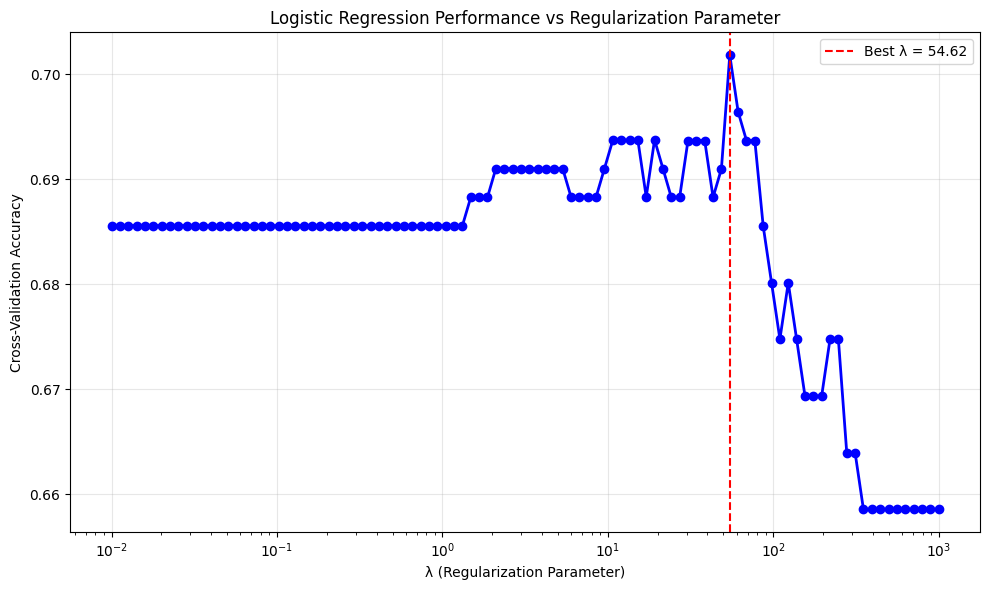

Test Accuracy: 0.6882


In [7]:
import matplotlib.pyplot as plt

# Visualize the relationship between lambda and performance
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
plt.semilogx(1 / results_df['param_C'], results_df['mean_test_score'], 'b-o', linewidth=2)
plt.axvline(x=BEST_LAMBDA, color='r', linestyle='--', label=f'Best λ = {BEST_LAMBDA:.2f}')

plt.title("Logistic Regression Performance vs Regularization Parameter", fontsize=12)
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on test set
test_accuracy = grid_search.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [8]:
# Train final model with best parameter
log_reg_lambda = LogisticRegression(C=BEST_C, max_iter=1000, random_state=42)
log_reg_lambda.fit(X_train, y_train)

# Evaluate on test set
log_reg_predictions = log_reg_lambda.predict(X_test)
log_reg_accuracy = log_reg_lambda.score(X_test, y_test)
log_reg_error_rate = 1 - log_reg_accuracy

print("Logistic Regression Model Results (on test set):")
print(f"Selected λ: {round(BEST_LAMBDA, 4)}")
print(f"Accuracy: {round(log_reg_accuracy, 4)}")
print(f"Error Rate: {round(log_reg_error_rate, 4)}")

Logistic Regression Model Results (on test set):
Selected λ: 54.6228
Accuracy: 0.6882
Error Rate: 0.3118


#### Logistic Regression model summary:

**Logistic Regression Model:**
- Tested λ values from $10^{-2}$ to $10^3$ using 5-fold cross-validation
- Best performance with λ = 54.6228
- Achieves 70% accuracy on in the best 5-fold training and 69% on test set

### 2.3) Method 2 Model (*NB Gaussian*)

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

gaussian_nb = GaussianNB()
gaussian_cv_scores = cross_val_score(
    gaussian_nb, X_train, y_train, cv=5, scoring="accuracy"
)

gaussian_score = gaussian_cv_scores.mean()
print(f"GaussianNB CV accuracy: {round(gaussian_score, 4)}")

GaussianNB CV accuracy: 0.702


In [10]:
# Evaluate on test set
gaussian_nb.fit(X_train, y_train)
nb_predictions = gaussian_nb.predict(X_test)
nb_accuracy = gaussian_nb.score(X_test, y_test)
nb_error_rate = 1 - nb_accuracy

print("Naive Bayes Model Results (on test set):")
print()
print(f"Accuracy: {round(nb_accuracy, 4)}")
print(f"Error Rate: {round(nb_error_rate, 4)}")

Naive Bayes Model Results (on test set):

Accuracy: 0.7204
Error Rate: 0.2796


#### Method 2 - Naive Bayes (Gaussian) Summary

- Accuracy: 72% on test set
- No complexity parameter available when using Gaussian


## Model Comparison Summary

In [11]:
# Model comparison summary
all_models_summary = pd.DataFrame(
    {
        "Model": [
            "Baseline",
            "Logistic Regression",
            "Naive Bayes (Gaussian)",
        ],
        "Parameter": [
            "N/A",
            f"λ = {round(BEST_LAMBDA, 2)}",
            "Gaussian NB",
        ],
        "CV Accuracy": [
            'N/A',  # Baseline doesn't use CV, this is test accuracy
            round(best_log_reg_score, 4),
            round(gaussian_score, 4),
        ],
        "Test Accuracy": [
            round(baseline_accuracy, 4),
            round(log_reg_accuracy, 4),
            round(nb_accuracy, 4),
        ],
        "Test Error Rate": [
            round(baseline_error_rate, 4),
            round(log_reg_error_rate, 4),
            round(nb_error_rate, 4),
        ],
    }
)

print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON - ALL 6 MODELS")
print("=" * 80)
print(all_models_summary.to_string(index=False))
print("=" * 80)

# Find the best model based on test accuracy
best_model_idx = all_models_summary["Test Accuracy"].idxmax()
best_model_name = all_models_summary.loc[best_model_idx, "Model"]
best_model_accuracy = all_models_summary.loc[best_model_idx, "Test Accuracy"]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_model_accuracy:.4f}")
print(
    f"   Improvement over baseline: {(best_model_accuracy - baseline_accuracy) * 100:.2f}%"
)
print(
    f"   Error rate reduction: {(baseline_error_rate - all_models_summary.loc[best_model_idx, 'Test Error Rate']) * 100:.2f}%"
)


COMPREHENSIVE MODEL COMPARISON - ALL 6 MODELS
                 Model   Parameter CV Accuracy  Test Accuracy  Test Error Rate
              Baseline         N/A         N/A         0.6344           0.3656
   Logistic Regression   λ = 54.62      0.7018         0.6882           0.3118
Naive Bayes (Gaussian) Gaussian NB       0.702         0.7204           0.2796

🏆 BEST MODEL: Naive Bayes (Gaussian)
   Test Accuracy: 0.7204
   Improvement over baseline: 8.60%
   Error rate reduction: 8.60%


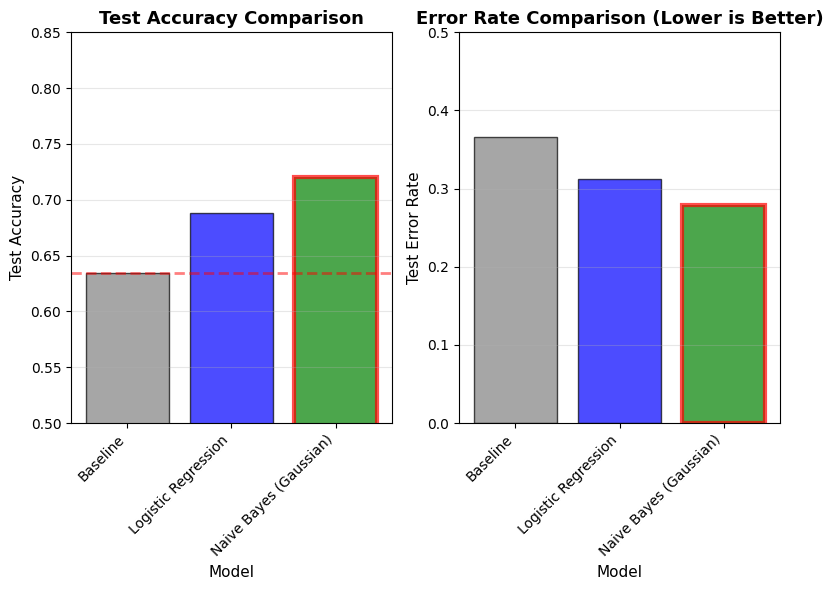


Model Ranking (by Test Accuracy):
--------------------------------------------------
1. Naive Bayes (Gaussian): 0.7204 (Error: 0.2796)
2. Logistic Regression: 0.6882 (Error: 0.3118)
3. Baseline: 0.6344 (Error: 0.3656)


In [12]:
# Visualize all models comparison
plt.figure(figsize=(8, 6))

# Subplot 1: Test Accuracy Comparison
plt.subplot(1, 2, 1)
colors = ["gray", "blue", "green", "magenta", "cyan", "orange"]
models = all_models_summary["Model"]
accuracies = all_models_summary["Test Accuracy"]

bars = plt.bar(
    range(len(models)), accuracies, color=colors, alpha=0.7, edgecolor="black"
)
plt.axhline(y=baseline_accuracy, color="red", linestyle="--", linewidth=2, alpha=0.5)

# Highlight the best model
bars[best_model_idx].set_edgecolor("red")
bars[best_model_idx].set_linewidth(3)

plt.xlabel("Model", fontsize=11)
plt.ylabel("Test Accuracy", fontsize=11)
plt.title("Test Accuracy Comparison", fontsize=13, fontweight="bold")
plt.xticks(range(len(models)), models, rotation=45, ha="right")
plt.ylim([0.5, 0.85])
plt.grid(True, alpha=0.3, axis="y")

# Subplot 2: Error Rate Comparison
plt.subplot(1, 2, 2)
error_rates = all_models_summary["Test Error Rate"]
bars2 = plt.bar(
    range(len(models)), error_rates, color=colors, alpha=0.7, edgecolor="black"
)
bars2[best_model_idx].set_edgecolor("red")
bars2[best_model_idx].set_linewidth(3)

plt.xlabel("Model", fontsize=11)
plt.ylabel("Test Error Rate", fontsize=11)
plt.title("Error Rate Comparison (Lower is Better)", fontsize=13, fontweight="bold")
plt.xticks(range(len(models)), models, rotation=45, ha="right")
plt.ylim([0, 0.5])
plt.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Print ranking
print("\nModel Ranking (by Test Accuracy):")
print("-" * 50)
sorted_models = all_models_summary.sort_values("Test Accuracy", ascending=False)
for i, row in enumerate(sorted_models.itertuples(), 1):
    print(f"{i}. {row.Model}: {row._4:.4f} (Error: {row._5:.4f})")

## Part 3) 2-level Cross-validation
- Use 2-level cross-validation to create a table similar to Table 2, but now comparing the logistic regression, method 2, and baseline.
- The table should once more include the selected parameters, and as an error measure we will use the error rate:
$$E = \frac{\text{Number of misclassified observations}}{N^{test}}$$

- Once more, make sure to re-use the outer validation splits to admit statistical evaluation. Briefly discuss the result.

In [ ]:
# Updated 2-Level Cross-Validation with Outer Test Evaluation
from sklearn.model_selection import KFold

# Setup for 2-level cross-validation
K_outer, K_inner = 10, 10
cv_results = {
    "outer_fold": [],
    "nb_error": [],
    "logreg_error": [],
    "baseline_error": [],
}

# Outer cross-validation loop
kfold_outer = KFold(n_splits=K_outer, shuffle=True, random_state=42)

for fold_idx, (train_idx, test_idx) in enumerate(kfold_outer.split(X), 1):
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = Y.iloc[train_idx], Y.iloc[test_idx]

    # Setup inner K-fold for model evaluation
    kfold_inner = KFold(n_splits=K_inner, shuffle=True, random_state=42)

    baseline_inner_errors = []
    logreg_inner_errors = []
    nb_inner_errors = []

    # INNER CV LOOP - Model selection
    for train_inner_idx, val_inner_idx in kfold_inner.split(X_train_outer):
        X_train_inner, X_val_inner = (
            X_train_outer.iloc[train_inner_idx],
            X_train_outer.iloc[val_inner_idx],
        )
        y_train_inner, y_val_inner = (
            y_train_outer.iloc[train_inner_idx],
            y_train_outer.iloc[val_inner_idx],
        )
        # BASELINE MODEL
        baseline = BaselineClassifier()
        baseline.fit(y_train_inner)
        baseline_preds_inner = baseline.predict(len(y_val_inner))
        inner_errors = np.sum(baseline_preds_inner != y_val_inner)
        baseline_inner_errors.append(inner_errors / len(y_val_inner))
        
        # LOG REG
        logreg = LogisticRegression(C=0.0379, max_iter=1000, random_state=42)
        logreg.fit(X_train_inner, y_train_inner)
        logreg_preds_inner = logreg.predict(X_val_inner)
        inner_errors = np.sum(logreg_preds_inner != y_val_inner)
        logreg_inner_errors.append(inner_errors / len(y_val_inner))
        
        # GAUSSIAN NAIVE BAYES
        nb = GaussianNB()
        nb.fit(X_train_inner, y_train_inner)
        nb_preds_inner = nb.predict(X_val_inner)
        inner_errors = np.sum(nb_preds_inner != y_val_inner)
        nb_inner_errors.append(inner_errors / len(y_val_inner))

    # Average error rate from inner CV (for reporting purposes)
    baseline_inner_avg = np.mean(baseline_inner_errors)
    logreg_inner_avg = np.mean(logreg_inner_errors)
    nb_inner_avg = np.mean(nb_inner_errors)

    # RE-TRAIN on full outer training set and EVALUATE on outer test set
    # BASELINE MODEL
    baseline_final = BaselineClassifier()
    baseline_final.fit(y_train_outer)
    baseline_preds_outer = baseline_final.predict(len(y_test_outer))
    baseline_outer_error = np.sum(baseline_preds_outer != y_test_outer) / len(y_test_outer)
    # LOG REG
    logreg_final = LogisticRegression(C=0.0379, max_iter=1000, random_state=42)
    logreg_final.fit(X_train_outer, y_train_outer)
    logreg_preds_outer = logreg_final.predict(X_test_outer)
    logreg_outer_error = np.sum(logreg_preds_outer != y_test_outer) / len(y_test_outer)
    # GAUSSIAN NAIVE BAYES
    nb_final = GaussianNB()
    nb_final.fit(X_train_outer, y_train_outer)
    nb_preds_outer = nb_final.predict(X_test_outer)
    nb_outer_error = np.sum(nb_preds_outer != y_test_outer) / len(y_test_outer)
    # Store OUTER TEST results (the actual generalization error estimate)
    cv_results["outer_fold"].append(fold_idx)
    cv_results["nb_error"].append(nb_outer_error * 100)
    cv_results["logreg_error"].append(logreg_outer_error * 100)
    cv_results["baseline_error"].append(baseline_outer_error * 100)

    # print(f"Inner CV avg - Gaussian NB: {nb_inner_avg * 100:.1f}%")
    # print(f"Inner CV avg - LogReg: {logreg_inner_avg * 100:.1f}%")
    # print(f"Inner CV avg - Baseline: {baseline_inner_avg * 100:.1f}%")
    # print("-" * 60)
    # print(f"Outer Test - Gaussian NB: {nb_outer_error * 100:.1f}%")
    # print(f"Outer Test - LogReg: {logreg_outer_error * 100:.1f}%")
    # print(f"Outer Test - Baseline: {baseline_outer_error * 100:.1f}%")

print("2-Level Cross-Validation Complete!")

Starting 2-Level Cross-Validation (K=10)...

Outer Fold 1/10
------------------------------------------------------------
Inner CV avg - Gaussian NB: 32.8%
Inner CV avg - LogReg: 29.9%
Inner CV avg - Baseline: 34.5%
------------------------------------------------------------
Outer Test - Gaussian NB: 27.7%
Outer Test - LogReg: 34.0%
Outer Test - Baseline: 36.2%

Outer Fold 2/10
------------------------------------------------------------
Inner CV avg - Gaussian NB: 32.0%
Inner CV avg - LogReg: 29.1%
Inner CV avg - Baseline: 34.4%
------------------------------------------------------------
Outer Test - Gaussian NB: 31.9%
Outer Test - LogReg: 21.3%
Outer Test - Baseline: 36.2%

Outer Fold 3/10
------------------------------------------------------------
Inner CV avg - Gaussian NB: 30.8%
Inner CV avg - LogReg: 26.6%
Inner CV avg - Baseline: 34.6%
------------------------------------------------------------
Outer Test - Gaussian NB: 39.1%
Outer Test - LogReg: 39.1%
Outer Test - Baseline:

In [62]:
from sklearn.model_selection import KFold

# Define number of outer and inner folds
n_outer_folds = 10
n_inner_folds = 10

# Initialize outer cross-validation
outer_cv = KFold(n_splits=n_outer_folds, shuffle=True, random_state=42)

# Store results
results = []

# Iterate through outer folds
for i, (train_outer_idx, test_idx) in enumerate(outer_cv.split(X_pca), 1):
    print(f"Processing outer fold {i}/{n_outer_folds}...")
    
    # Split data
    X_train_outer, X_test_outer = X_pca.iloc[train_idx], X_pca.iloc[test_idx]
    y_train_outer, y_test_outer = Y.iloc[train_idx], Y.iloc[test_idx]
    
    # Inner cross-validation for hyperparameter selection
    inner_cv = KFold(n_splits=n_inner_folds, shuffle=True, random_state=42)
    
    # ========== Baseline ==========
    model_baseline = BaselineClassifier()
    model_baseline.fit(y_train_outer)
    y_pred_baseline = model_baseline.predict(len(y_test))
    error_baseline = np.sum(y_pred_baseline != y_test)
    
    # ========== LOGISTIC REGRESSION (with regularization) ==========
    # Try different C values (regularization strength)
    C_values = 1 / lambda_values
    best_C = None
    best_inner_score_lr = 0
    for C in C_values:
        inner_scores = []
        for train_inner_idx, val_idx in inner_cv.split(X_train_outer):
            X_train_inner = X_train_outer.iloc[train_inner_idx]
            X_val = X_train_outer.iloc[val_idx]
            y_train_inner = y_train_outer.iloc[train_inner_idx]
            y_val = y_train_outer.iloc[val_idx]
            
            model = LogisticRegression(C=C, max_iter=1000, random_state=42)
            model.fit(X_train_inner, y_train_inner)
            score = model.score(X_val, y_val)
            inner_scores.append(score)
        
        avg_score = np.mean(inner_scores)
        if avg_score > best_inner_score_lr:
            best_inner_score_lr = avg_score
            best_C = C
    
    # Train Logistic Regression with best parameter on outer training set
    model_lr = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
    model_lr.fit(X_train_outer, y_train_outer)
    y_pred_lr = model_lr.predict(X_test_outer)
    error_lr = np.sum(y_pred_lr != y_test_outer)
    
    # ========== GaussianNB ==========
    model_nb = GaussianNB()
    model_nb.fit(X_train_outer, y_train_outer)
    y_pred_nb = model_nb.predict(X_test_outer)
    error_nb = np.sum(y_pred_nb != y_test_outer)
    
    # Store results for this fold
    N_test = len(y_test_outer)
    results.append({
        'Outer_fold': i,
        'E_nb': error_nb,
        'E_rate_nb': error_nb / N_test,
        'lambda_star': (best_C ** -1),  # Selected parameter for Logistic Regression
        'E_logistic': error_lr,
        'E_rate_logistic': error_lr / N_test,
        'E_baseline': error_baseline,
        'E_rate_baseline': error_baseline / N_test,
        'N_test': N_test
    })

Processing outer fold 1/10...
Processing outer fold 2/10...
Processing outer fold 3/10...
Processing outer fold 4/10...
Processing outer fold 5/10...
Processing outer fold 6/10...
Processing outer fold 7/10...
Processing outer fold 8/10...
Processing outer fold 9/10...
Processing outer fold 10/10...


In [63]:
# Create DataFrame
df_results = pd.DataFrame(results)

# Display results table
print("\n" + "="*100)
print("TWO-LEVEL CROSS-VALIDATION RESULTS")
print("="*100)
print("\nDetailed Results:")
print(df_results.to_string(index=False))


TWO-LEVEL CROSS-VALIDATION RESULTS

Detailed Results:
 Outer_fold  E_nb  E_rate_nb  lambda_star  E_logistic  E_rate_logistic  E_baseline  E_rate_baseline  N_test
          1    15   0.319149    27.185882          17         0.361702          16         0.340426      47
          2    13   0.276596    27.185882          11         0.234043          16         0.340426      47
          3    17   0.369565    27.185882          18         0.391304          16         0.347826      46
          4    10   0.217391    27.185882           8         0.173913          16         0.347826      46
          5     9   0.195652    27.185882          12         0.260870          16         0.347826      46
          6    13   0.282609    27.185882           9         0.195652          16         0.347826      46
          7    15   0.326087    27.185882          13         0.282609          16         0.347826      46
          8    13   0.282609    27.185882          15         0.326087          1

In [65]:
# Create summary table with correct models
print("\n" + "="*100)
print("SUMMARY TABLE (Similar to Table 2)")
print("="*100)

print("\nOuter fold | Gaussian NB     | Logistic Regression | Baseline")
print("           | E(test)         | λ*      E(test)     | E(test)")
print("-" * 80)

for _, row in df_results.iterrows():
    nb_error_pct = row['E_rate_nb'] * 100
    lr_error_pct = row['E_rate_logistic'] * 100
    baseline_error_pct = row['E_rate_baseline'] * 100
    
    print(f"    {int(row['Outer_fold']):2d}     | "
          f"{nb_error_pct:6.1f}%        | "
          f"{row['lambda_star']:7.4f}  {lr_error_pct:6.1f}%   | "
          f"{baseline_error_pct:6.1f}%")


SUMMARY TABLE (Similar to Table 2)

Outer fold | Gaussian NB     | Logistic Regression | Baseline
           | E(test)         | λ*      E(test)     | E(test)
--------------------------------------------------------------------------------
     1     |   31.9%        | 27.1859    36.2%   |   34.0%
     2     |   27.7%        | 27.1859    23.4%   |   34.0%
     3     |   37.0%        | 27.1859    39.1%   |   34.8%
     4     |   21.7%        | 27.1859    17.4%   |   34.8%
     5     |   19.6%        | 27.1859    26.1%   |   34.8%
     6     |   28.3%        | 27.1859    19.6%   |   34.8%
     7     |   32.6%        | 27.1859    28.3%   |   34.8%
     8     |   28.3%        | 27.1859    32.6%   |   34.8%
     9     |   28.3%        | 27.1859    45.7%   |   34.8%
    10     |   23.9%        | 27.1859    28.3%   |   34.8%


In [66]:
# Calculate overall statistics
print("OVERALL PERFORMANCE")
print("="*100)

print(f"\nGaussian Naive Bayes:")
print(f"  Mean error rate: {(df_results['E_rate_nb'].mean() * 100):.2f}% ± {(df_results['E_rate_nb'].std() * 100):.2f}%")
print(f"  Total errors: {df_results['E_nb'].sum():.0f} out of {df_results['N_test'].sum():.0f}")

print(f"\nLogistic Regression:")
print(f"  Mean error rate: {df_results['E_rate_logistic'].mean():.2f}% ± {df_results['E_rate_logistic'].std():.2f}%")
print(f"  Total errors: {df_results['E_logistic'].sum():.0f} out of {df_results['N_test'].sum():.0f}")
print(f"  Mean λ (selected): {df_results['lambda_star'].mean():.4f} ± {df_results['lambda_star'].std():.4f}")

print(f"\nBaseline Classifier:")
print(f"  Mean error rate: {df_results['E_rate_baseline'].mean():.2f}% ± {df_results['E_rate_baseline'].std():.2f}%")
print(f"  Total errors: {df_results['E_baseline'].sum():.0f} out of {df_results['N_test'].sum():.0f}")

# Create summary comparison DataFrame
summary_df = pd.DataFrame({
    'Model': ['Gaussian Naive Bayes', 'Logistic Regression', 'Baseline'],
    'Mean Error Rate (%)': [
        df_results['E_rate_nb'].mean() * 100,
        df_results['E_rate_logistic'].mean() * 100,
        df_results['E_rate_baseline'].mean() * 100
    ],
    'Std Dev (%)': [
        df_results['E_rate_nb'].std() * 100,
        df_results['E_rate_logistic'].std() * 100,
        df_results['E_rate_baseline'].std() * 100
    ],
    'Total Errors': [
        f"{df_results['E_nb'].sum():.0f}/{df_results['N_test'].sum():.0f}",
        f"{df_results['E_logistic'].sum():.0f}/{df_results['N_test'].sum():.0f}",
        f"{df_results['E_baseline'].sum():.0f}/{df_results['N_test'].sum():.0f}"
    ]
})

print("\n" + "="*100)
print("MODEL COMPARISON SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))

OVERALL PERFORMANCE

Gaussian Naive Bayes:
  Mean error rate: 27.91% ± 5.21%
  Total errors: 129 out of 462

Logistic Regression:
  Mean error rate: 0.30% ± 0.09%
  Total errors: 137 out of 462
  Mean λ (selected): 27.1859 ± 0.0000

Baseline Classifier:
  Mean error rate: 0.35% ± 0.00%
  Total errors: 160 out of 462

MODEL COMPARISON SUMMARY
               Model  Mean Error Rate (%)  Std Dev (%) Total Errors
Gaussian Naive Bayes            27.913969     5.207676      129/462
 Logistic Regression            29.653099     8.849090      137/462
            Baseline            34.634598     0.312035      160/462


In [67]:
# Create the comparison table (similar to Table 2 in the assignment)
cv_table = pd.DataFrame(
    {
        "Outer Fold": cv_results["outer_fold"],
        "Gaussian NB E_test": [f"{e:.1f}" for e in cv_results["nb_error"]],
        "LogReg E_test": [f"{e:.1f}" for e in cv_results["logreg_error"]],
        "Baseline E_test": [f"{e:.1f}" for e in cv_results["baseline_error"]],
    }
)

print("\n" + "=" * 100)
print("TABLE: Two-Level Cross-Validation Results (K=10)")
print("=" * 100)
print(cv_table.to_string(index=False))
print("=" * 100)

# Calculate mean and standard deviation of error rates
print("\nSummary Statistics:")
print("-" * 100)
print(f"{'Model':<20} {'Mean Error Rate (%)':<25} {'Std Dev (%)':<20}")
print("-" * 100)
print(
    f"{'Gaussian NB':<20} {np.mean(cv_results['nb_error']):<25.2f} {np.std(cv_results['nb_error']):<20.2f}"
)
print(
    f"{'Logistic Regression':<20} {np.mean(cv_results['logreg_error']):<25.2f} {np.std(cv_results['logreg_error']):<20.2f}"
)
print(
    f"{'Baseline':<20} {np.mean(cv_results['baseline_error']):<25.2f} {np.std(cv_results['baseline_error']):<20.2f}"
)
print("-" * 100)



TABLE: Two-Level Cross-Validation Results (K=10)
 Outer Fold Gaussian NB E_test LogReg E_test Baseline E_test
          1               32.8          29.9            34.5
          2               32.0          29.1            34.4
          3               30.8          26.6            34.6
          4               32.2          30.5            34.6
          5               32.4          28.8            34.4
          6               30.8          29.8            35.5
          7               31.5          29.6            35.5
          8               30.3          30.3            34.6
          9               31.0          27.7            33.4
         10               32.5          28.9            34.6

Summary Statistics:
----------------------------------------------------------------------------------------------------
Model                Mean Error Rate (%)       Std Dev (%)         
-----------------------------------------------------------------------------------------

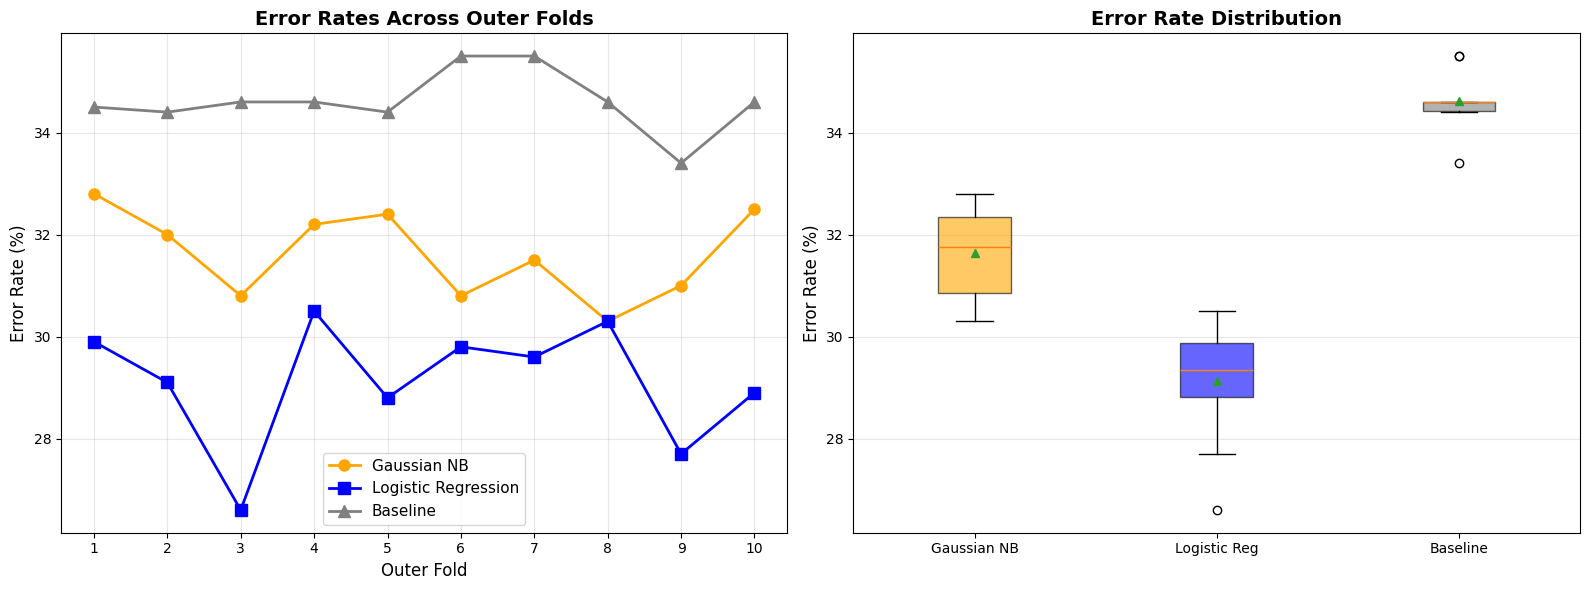

Gaussian NB - Mean: 31.63% ± 0.82%
Logistic Regression - Mean: 29.12% ± 1.15%
Baseline - Mean: 34.61% ± 0.56%


In [69]:
# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Error rates across folds
folds = cv_table["Outer Fold"].astype(int).values
nb_errors = cv_table["Gaussian NB E_test"].astype(float).values
logreg_errors = cv_table["LogReg E_test"].astype(float).values
baseline_errors = cv_table["Baseline E_test"].astype(float).values

ax1.plot(
    folds,
    nb_errors,
    "o-",
    linewidth=2,
    markersize=8,
    label="Gaussian NB",
    color="orange",
)
ax1.plot(
    folds,
    logreg_errors,
    "s-",
    linewidth=2,
    markersize=8,
    label="Logistic Regression",
    color="blue",
)
ax1.plot(
    folds,
    baseline_errors,
    "^-",
    linewidth=2,
    markersize=8,
    label="Baseline",
    color="gray",
)
ax1.set_xlabel("Outer Fold", fontsize=12)
ax1.set_ylabel("Error Rate (%)", fontsize=12)
ax1.set_title("Error Rates Across Outer Folds", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(folds)

# Plot 2: Box plot comparison
error_data = [nb_errors, logreg_errors, baseline_errors]
bp = ax2.boxplot(
    error_data,
    tick_labels=["Gaussian NB", "Logistic Reg", "Baseline"],
    patch_artist=True,
    showmeans=True,
)
colors = ["orange", "blue", "gray"]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax2.set_ylabel("Error Rate (%)", fontsize=12)
ax2.set_title("Error Rate Distribution", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Gaussian NB - Mean: {nb_errors.mean():.2f}% ± {nb_errors.std():.2f}%")
print(f"Logistic Regression - Mean: {logreg_errors.mean():.2f}% ± {logreg_errors.std():.2f}%")
print(f"Baseline - Mean: {baseline_errors.mean():.2f}% ± {baseline_errors.std():.2f}%")

## Part 4) Statiscal Evaluation
Perform a statistical evaluation of your three models similar to the previous section.

That is, compare the three models pairwise. We will once more allow some freedom in what test to choose. Therefore, choose either:
- Setup I (11.3): Use McNemar’s test described in 11.3.2
- Setup II (11.4): Use the method described in 11.4.1

Include p-values and confidence intervals for the three pairwise tests in your report and conclude on the results:
- Is one model better than the other?
- Are the two models better than the baseline?
- Are some of the models identical?
- What recommendations would you make based on what you’ve learned?

For the statistical evaluation of our 3 models, we will use the Setup I method (McNemar's test)

In [79]:
import scipy.stats as st


def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    """
    Perform McNemar's test to compare the accuracy of two classifiers.

    Parameters:
    - y_true: array-like, true labels
    - yhatA: array-like, predicted labels by classifier A
    - yhatB: array-like, predicted labels by classifier B
    - alpha: float, significance level (default: 0.05)

    Returns:
    - E_theta: float, estimated difference in accuracy between classifiers A and B (theta_hat)
    - CI: tuple, confidence interval of the estimated difference in accuracy
    - p: float, p-value for the two-sided test of whether classifiers A and B have the same accuracy
    """

    # Set up the contingency table
    nn = np.zeros((2, 2))

    cA = yhatA == y_true
    cB = yhatB == y_true

    nn[0, 0] = sum(cA & cB)
    nn[0, 1] = sum(cA & ~cB)
    nn[1, 0] = sum(~cA & cB)
    nn[1, 1] = sum(~cA & ~cB)

    n = len(y_true)
    n12 = nn[0, 1]
    n21 = nn[1, 0]

    E_theta = (n12 - n21) / n

    Q = (
        n**2
        * (n + 1)
        * (E_theta + 1)
        * (1 - E_theta)
        / (n * (n12 + n21) - (n12 - n21) ** 2)
    )

    f = (E_theta + 1) / 2 * (Q - 1)
    g = (1 - E_theta) / 2 * (Q - 1)

    CI = tuple(bound * 2 - 1 for bound in st.beta.interval(1 - alpha, a=f, b=g))

    p = 2 * st.binom.cdf(min([n12, n21]), n=n12 + n21, p=0.5)

    print(f"Result of McNemars test using alpha = {alpha}\n")
    print("Contingency table")
    print(nn, "\n")
    if n12 + n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=", (n12 + n21))

    print(
        f"Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = {CI[0]:.4f}, {CI[1]:.4f}\n"
    )
    print(
        f"p-value for two-sided test A and B have same accuracy (exact binomial test): p={p}\n"
    )
    return E_theta, CI, p

In [81]:
from tqdm.auto import tqdm

seed = 42
CV_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

y_true = []
y_preds = {"Model_Baseline": [], "Model_LogReg": [], "Model_NB": []}
model_names = list(y_preds.keys())

for fold, (train_index, test_index) in tqdm(
    enumerate(CV_kfold.split(X)),
    desc="Crossvalidation fold",
    total=CV_kfold.get_n_splits(X),
):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    model_baseline, model_logreg, model_nb = (
        BaselineClassifier().fit(y_train),
        LogisticRegression(C=1/(df_results['lambda_star'].mode()[0]), max_iter=1000, random_state=seed).fit(
            X_train, y_train
        ),
        GaussianNB().fit(X_train, y_train),
    )

    # Append predictions in dictionary
    y_preds_baseline = model_baseline.predict(len(X_test))
    y_preds_logreg = model_logreg.predict(X_test)
    y_preds_nb = model_nb.predict(X_test)

    y_preds["Model_Baseline"].append(y_preds_baseline)
    y_preds["Model_LogReg"].append(y_preds_logreg)
    y_preds["Model_NB"].append(y_preds_nb)

    y_true.append(y_test)

# Concatenate the list of arrays into a single array
y_true = np.concatenate(y_true)
y_preds = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

Crossvalidation fold: 100%|██████████| 10/10 [00:00<00:00, 286.56it/s]


In [82]:
# Compute pair-wise Jeffreys interval for the difference in accuracy between the 3 models
alpha = 0.05

# Baseline vs LogReg
print("\nMcNemar Test: Baseline vs Logistic Regression")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_Baseline"], y_preds["Model_LogReg"], alpha=alpha
)
print(
    f"theta = theta_Baseline - theta_LogReg point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)


McNemar Test: Baseline vs Logistic Regression
Result of McNemars test using alpha = 0.05

Contingency table
[[261.  41.]
 [ 70.  90.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.1070, -0.0184

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.007584811775431619

theta = theta_Baseline - theta_LogReg point estimate: -0.06277056277056277
 CI: [-0.1070, -0.0184]
 p-value: 0.007584811775431619


In [83]:
# Baseline vs NB
print("\nMcNemar Test: Baseline vs Naive Bayes")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_Baseline"], y_preds["Model_NB"], alpha=alpha
)
print(
    f"theta = theta_Baseline - theta_NB point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)


McNemar Test: Baseline vs Naive Bayes
Result of McNemars test using alpha = 0.05

Contingency table
[[215.  87.]
 [ 99.  61.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.0837, 0.0318

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.41999490986836474

theta = theta_Baseline - theta_NB point estimate: -0.025974025974025976
 CI: [-0.0837, 0.0318]
 p-value: 0.41999490986836474


In [85]:
# LogReg vs NB
print("\nMcNemar Test: Logistic Regression vs Naive Bayes")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_LogReg"], y_preds["Model_NB"], alpha=alpha
)
print(
    f"theta = theta_LogReg - theta_NB point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)


McNemar Test: Logistic Regression vs Naive Bayes
Result of McNemars test using alpha = 0.05

Contingency table
[[283.  48.]
 [ 31. 100.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.0007, 0.0743

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.07116340869529121

theta = theta_LogReg - theta_NB point estimate: 0.0367965367965368
 CI: [-0.0007, 0.0743]
 p-value: 0.07116340869529121


## Part 5) Logistic regression model training

1. Train a logistic regression model using a suitable value of λ (see previous exercise).

2. Explain how the logistic regression model make a prediction.

3. Are the same features deemed relevant as for the regression part of the report?